# Introdução ao CUDA

Esta pode ser considerada uma introdução mínima ao CUDA e às possibilidades de uso neste ambiente. 

---
##  Configurando e instalando 

Para acessar GPUs NVIDIA no Google Colab é preciso alterar a configuração do ambiente. Para isso, clique no menu superior em **Runtime > Change runtime type**, em **Hardware accelerator** selecione **GPU** e clique em **Save**. Esta configuração é persistente, ou seja, o arquivo já será inicializado neste ambiente da próxima vez que for aberto. 

O compilador CUDA `nvcc` já vem instalado e pode ser invocado como vemos abaixo, solicitando sua versão com o parâmetro `--version`:

In [ ]:
!nvcc --version

O comando e `nvidia-smi` _(Systems Management Interface)_ nos dá detalhes do ambiente, tais como aceleradores disponíveis e processos em execução:

In [ ]:
!nvidia-smi

Para facilitar ainda mais, vamos instalar a extensão `nvcc_plugin` que permite escrever e executar código CUDA diretamente nas células do Jupyter:

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Depois disso, basta usar o prefixo `%%cu` no início da célula para rodar código CUDA diretamente no Jupyter sem a necessidade de invocar explicitamente o compilador:

In [ ]:
%%cu
#include <iostream>
int main() {
  int nDevices;
	std::cout << "Welcome to CUDA!" << std::endl;
  cudaGetDeviceCount(&nDevices);
  for (int i = 0; i < nDevices; i++) {
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, i);
    std::cout << "Device Number: " << i << std::endl;
    std::cout << "  Device name: " << prop.name << std::endl;
    std::cout << "  Memory Clock Rate (KHz): " << prop.memoryClockRate << std::endl;
    std::cout << "  Memory Bus Width (bits): " << prop.memoryBusWidth << std::endl;
    std::cout << "  Peak Memory Bandwidth (GB/s): " << 2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6 << std::endl;
  }
	return 0;
}


---
## Pré-requisitos

Para aproveitar ao máximo este laboratório, você já deve ser capaz de:

- Declarar variáveis, escrever loops e usar instruções `if/else` em C.
- Definir e invocar funções em C.
- Alocar arrays em C.

Nenhum conhecimento prévio de CUDA é necessário.

---
## Objetivos

Ao concluir este laboratório, você será capaz de:

- Escrever, compilar e executar programas C/C++ que chamam funções de CPU e **disparam** **kernels** em GPU.
- Controlar a **hierarquia de threads** paralela usando a **configuração de execução**.
- Refatorar loops seriais para executar suas iterações em paralelo em uma GPU.
- Alocar e liberar memória disponível para CPUs e GPUs.
- Manipular erros gerados pelo código CUDA.
- Acelerar aplicativos somente de CPU.

---
## Escrevendo o código da aplicação para a GPU

CUDA fornece extensões para muitas linguagens de programação comuns, no caso deste laboratório, C/C++. Essas extensões de linguagem permitem que os desenvolvedores executem facilmente funções em seu código-fonte em uma GPU.

Abaixo está um arquivo `.cu` (extensão do arquivo para programas acelerados por CUDA). Ele contém duas funções, a primeira que será executada na CPU, a segunda que será executada na GPU. Gaste um tempo identificando as diferenças entre as funções, tanto em termos de como elas são definidas quanto de como são invocadas.

In [ ]:
%%writefile 01-hello-gpu.cu
#include <stdio.h>

void CPUFunction() {
  printf("Esta função está definida para ser executada na CPU.\n");
}

__global__ void GPUFunction() {
  printf("Esta função está definida para ser executada na GPU.\n");
}

int main() {
  CPUFunction();
  GPUFunction<<<1, 1>>>();
  cudaDeviceSynchronize();
  return 0;
}


Aqui estão algumas linhas de código importantes para destacar, bem como alguns outros termos comuns usados ​​em computação acelerada:

`__global__ void GPUFunction()`
  - A palavra-chave `__global__` indica que a seguinte função será executada na GPU e pode ser invocada **globalmente**, o que neste contexto significa tanto pela CPU quanto pela GPU.
  - Muitas vezes, o código executado na CPU é chamado de código do **host**, e o código executado na GPU é chamado de código do **dispositivo** ou **acelerador**.
  - Observe o tipo de retorno `void`. É necessário que as funções definidas com a palavra-chave `__global__` retornem o tipo `void`.

`GPUFunction<<<1, 1>>>();`
  - Normalmente, ao chamar uma função para execução na GPU, chamamos essa função de **kernel**, que é **disparada** ou **lançada**.
  - Ao lançar um kernel, devemos fornecer uma **configuração de execução**, que é feita usando a sintaxe `<<< ... >>>` antes de passar ao kernel quaisquer argumentos esperados.
  - Em um nível alto, a configuração de execução permite que os programadores especifiquem a **hierarquia de threads** para uma inicialização do kernel, que define o número de agrupamentos de threads (chamados **blocos**), bem como quantos **threads** para executar em cada bloco. A configuração de execução será explorada detalhadamente mais adiante no laboratório, mas, por enquanto, observe que o kernel está sendo iniciado com `1` bloco de threads (o primeiro argumento de configuração de execução) que contém `1` thread (o segundo argumento de configuração) .

`cudaDeviceSynchronize();`
  - Ao contrário de muitos códigos C/C++, o lançamento de kernels é **assíncrono**: o código da CPU continuará a ser executado *sem esperar que o lançamento do kernel seja concluído*.
  - Uma chamada para `cudaDeviceSynchronize`, uma função fornecida pelo runtime CUDA, fará com que o código do host (CPU) espere até que o código do dispositivo (GPU) seja concluído e só então retome a execução na CPU.

---
## Experimente você!

Abaixo invocamos o compilador `nvcc` para compilar e executar (usando o parâmetro `-run`) o arquivo criado na célula anterior. Execute a célula abaixo para ver o resultado... 

O parâmetro `-arch=` permite escolher a arquitetura alvo da GPU, experimente trocar para `sm_50` e veja o que acontece. 

Volte na célula que gerou o arquivo e experimente mudar o número de blocos e threads. Não esqueça de executar a célula para salvar novamente o arquivo.

In [ ]:
!nvcc -arch=sm_70 -o hello-gpu 01-hello-gpu.cu -run

---
## Índices de threads e blocos

Cada thread recebe um índice dentro de seu bloco de threads, começando em `0`. Além disso, cada bloco recebe um índice, começando em '0'. Assim como os encadeamentos são agrupados em blocos de encadeamentos, os blocos são agrupados em uma **grade (grid)**, que é a entidade mais alta na hierarquia de encadeamentos CUDA. Em resumo, os kernels CUDA são executados em uma grade de 1 ou mais blocos, com cada bloco contendo o mesmo número de 1 ou mais threads.

Kernels CUDA têm acesso a variáveis ​​especiais que identificam tanto o índice da thread (dentro do bloco) que está executando o kernel, quanto o índice do bloco (dentro da grade) em que a thread está. Essas variáveis ​​são `threadIdx.x` e `blockIdx.x` respectivamente.

In [ ]:
%%writefile 02-thread-and-block-idx.cu
#include <stdio.h>

__global__ void printSuccessForCorrectExecutionConfiguration() {
  if(threadIdx.x == 1023 && blockIdx.x == 255)
    printf("Success!\n");
}

int main() {
  /* This is one possible execution context that will make
   * the kernel launch print its success message. */
  printSuccessForCorrectExecutionConfiguration<<<256, 1024>>>();

  /* Don't forget kernel execution is asynchronous and you must
   * sync on its completion. */
  cudaDeviceSynchronize();
}


In [ ]:
!nvcc -arch=sm_70 -o thread-and-block-idx 02-thread-and-block-idx.cu -run

---
## Acelerando loops `for` 

Loops `for` em aplicativos somente de CPU estão prontos para aceleração: em vez de executar cada iteração do loop em série, cada iteração do loop pode ser executada em paralelo em seu próprio thread. Considere o seguinte loop for e observe, embora seja óbvio, que ele controla quantas vezes o loop será executado, além de definir o que acontecerá para cada iteração do loop:

```cpp
int N = 2<<20;
for (int i = 0; i < N; ++i) {
  printf("%d\n", i);
}
```

Para paralelizar este loop, 2 passos devem ser seguidos:

- Um kernel deve ser escrito para fazer o trabalho de uma **única iteração do loop**.
- Como o kernel será independente de outros kernels em execução, a configuração de execução deve ser tal que o kernel execute o número correto de vezes, por exemplo, o número de vezes que o loop teria iterado.

In [ ]:
%%writefile 03-single-block-loop.cu
#include <stdio.h>

/*
 * Notice the absence of the previously expected argument `N`.
 */

__global__ void loop() {
  /* This kernel does the work of only 1 iteration
   * of the original for loop. Indication of which
   * "iteration" is being executed by this kernel is
   * still available via `threadIdx.x`.  */
  printf("This is iteration number %d\n", threadIdx.x);
}

int main() {
  /* It is the execution context that sets how many "iterations"
   * of the "loop" will be done.
   */
  loop<<<1, 10>>>();
  cudaDeviceSynchronize();
}

In [ ]:
!nvcc -arch=sm_70 -o single-block-loop 03-single-block-loop.cu -run

---
## Usando dimensões de bloco para mais paralelização

Há um limite para o número de threads que podem existir em um bloco de thread: 1024 para ser preciso. Para aumentar a quantidade de paralelismo em aplicativos acelerados, devemos ser capazes de coordenar entre vários blocos de threads.

Kernels CUDA têm acesso a uma variável especial que fornece o número de threads em um bloco: `blockDim.x`. Usando essa variável, em conjunto com `blockIdx.x` e `threadIdx.x`, a paralelização aumentada pode ser realizada organizando a execução paralela em vários blocos de vários threads com a expressão idiomática `threadIdx.x + blockIdx.x * blockDim.x `. Aqui está um exemplo detalhado.

A configuração de execução `<<<10, 10>>>` lançaria um grid com um total de 100 threads, contidos em 10 blocos de 10 threads. Esperamos, portanto, que cada thread tenha a capacidade de calcular algum índice exclusivo entre `0` e `99`.

- Se o bloco `blockIdx.x` for igual a `0`, então `blockIdx.x * blockDim.x` será `0`. Adicionando a `0` os possíveis valores `threadIdx.x` `0` a `9`, então podemos gerar os índices `0` a `9` dentro da grade de 100 threads.
- Se o bloco `blockIdx.x` for igual a `1`, então `blockIdx.x * blockDim.x` será `10`. Adicionando a `10` os possíveis valores `threadIdx.x` `0` a `9`, então podemos gerar os índices `10` a `19` dentro da grade de 100 threads.
- Se o bloco `blockIdx.x` for igual a `5`, então `blockIdx.x * blockDim.x` será `50`. Adicionando a `50` os possíveis valores `threadIdx.x` de `0` a `9`, podemos gerar os índices de `50` a `59` dentro da grade de 100 threads.
- Se o bloco `blockIdx.x` for igual a `9`, então `blockIdx.x * blockDim.x` será `90`. Adicionando a `90` os possíveis valores `threadIdx.x` `0` a `9`, então podemos gerar os índices `90` a `99` dentro da grade de 100 threads.

In [ ]:
%%writefile 04-multi-block-loop.cu
#include <stdio.h>

__global__ void loop() {
  /* This idiomatic expression gives each thread
   * a unique index within the entire grid.
   */
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  printf("%d\n", i);
}

int main() {
  /* Additional execution configurations that would
   * work and meet the exercises contraints are:
   * <<<5, 2>>>
   * <<<10, 1>>> */
  loop<<<2, 5>>>();
  cudaDeviceSynchronize();
}


In [ ]:
!nvcc -arch=sm_70 -o multi-block-loop 04-multi-block-loop.cu -run

---
## Alocação de memória a ser acessada na GPU e na CPU

Versões mais recentes do CUDA (versão 6 e posterior) facilitaram a alocação de memória disponível tanto para o host da CPU quanto para qualquer número de dispositivos GPU e, embora existam muitas [técnicas intermediárias e avançadas](http://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations) para gerenciamento de memória que oferecerá suporte ao melhor desempenho em aplicativos acelerados, a técnica de gerenciamento de memória CUDA mais básica que abordaremos agora oferece suporte a ganhos de desempenho fantásticos em aplicativos somente de CPU com quase nenhuma sobrecarga de desenvolvedor.

Para alocar e liberar memória e obter um ponteiro que possa ser referenciado no código do host e do dispositivo, substitua as chamadas para `malloc` e `free` por `cudaMallocManaged` e `cudaFree` como no exemplo a seguir:


```cpp
// CPU-only
int N = 2<<20;
size_t size = N * sizeof(int);

int *a;
a = (int *)malloc(size);

// Use `a` in CPU-only program.
free(a);
```

```cpp
// Accelerated
int N = 2<<20;
size_t size = N * sizeof(int);

int *a;
// Note the address of `a` is passed as first argument.
cudaMallocManaged(&a, size);

// Use `a` on the CPU and/or on any GPU in the accelerated system.
cudaFree(a);
```

In [ ]:
%%writefile 05-double-elements.cu
#include <stdio.h>

void init(int *a, int N) {
  int i;
  for (i = 0; i < N; ++i) 
    a[i] = i;
}

__global__ void doubleElements(int *a, int N) {
  int i;
  i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i < N)
    a[i] *= 2;
}

bool checkElementsAreDoubled(int *a, int N) {
  int i;
  for (i = 0; i < N; ++i)
    if (a[i] != i*2) 
      return false;
  return true;
}

int main() {
  int N = 1000;
  int *a;

  size_t size = N * sizeof(int);
  /* Use `cudaMallocManaged` to allocate pointer `a` available
   * on both the host and the device. */

  cudaMallocManaged(&a, size);
  init(a, N);

  size_t threads_per_block = 256;
  size_t number_of_blocks = (N + threads_per_block - 1) / threads_per_block;

  doubleElements<<<number_of_blocks, threads_per_block>>>(a, N);
  cudaDeviceSynchronize();

  bool areDoubled = checkElementsAreDoubled(a, N);
  printf("All elements were doubled? %s\n", areDoubled ? "TRUE" : "FALSE");

  /* Use `cudaFree` to free memory allocated with `cudaMallocManaged`. */
  cudaFree(a);
}


In [ ]:
!nvcc -arch=sm_70 -o double-elements 05-double-elements.cu -run

---
## Tratamento de incompatibilidades de configuração de bloco com o número de threads necessários

Pode ser que uma configuração de execução não possa ser expressa para criar o número exato de threads necessários para paralelizar um loop.

Um exemplo comum tem a ver com o desejo de escolher tamanhos de bloco ideais. Por exemplo, devido às características de hardware da GPU, os blocos que contêm vários threads que são múltiplos de 32 geralmente são desejáveis ​​para benefícios de desempenho. Supondo que queríamos lançar blocos cada um contendo 256 threads (um múltiplo de 32) e precisávamos executar 1.000 tarefas paralelas (um número trivialmente pequeno para facilitar a explicação), então não há número de blocos que produziria um total exato de 1000 threads na grade, pois não há valor inteiro 32 pode ser multiplicado por exatamente 1000.

Este cenário pode ser facilmente resolvido da seguinte maneira:

- Escreva uma configuração de execução que crie **mais** threads do que o necessário para realizar o trabalho alocado.
- Passar um valor como argumento no kernel (`N`) que representa o tamanho total do conjunto de dados a ser processado, ou o total de threads que são necessários para concluir o trabalho.
- Após calcular o índice da thread dentro da grade (usando `tid+bid*bdim`), verifique se este índice não excede `N`, e só execute o trabalho pertinente do kernel se não exceder.

Aqui está um exemplo de uma maneira idiomática de escrever uma configuração de execução quando tanto `N` quanto o número de threads em um bloco são conhecidos e uma correspondência exata entre o número de threads na grade e `N` não pode ser garantida. Ele garante que sempre haja pelo menos tantos encadeamentos quantos forem necessários para `N`, e apenas 1 bloco adicional de encadeamentos extras, no máximo:

```cpp
// Suponha que `N` seja conhecido
int N = 100000;

// Suponha que desejamos definir `threads_per_block` exatamente como `256`
size_t threads_per_block = 256;

// Certifique-se de que haja pelo menos `N` threads na grade, com apenas 1 bloco excedente
size_t number_of_blocks = (N + threads_per_block - 1) / threads_per_block;

some_kernel<<<number_of_blocks, threads_per_block>>>(N);
```

Como a configuração de execução acima resulta em mais threads na grade do que `N`, deve-se tomar cuidado dentro da definição de `some_kernel` para que `some_kernel` não tente acessar elementos de dados fora do intervalo, ao ser executado por um dos tópicos "extras":

```cpp 
__global__ some_kernel(int N) {
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  if (idx < N) { // Verifica se `idx` mapeia para algum valor dentro de `N`
    // Só executa em caso verdadeiro
  }
}
```

In [ ]:
%%writefile 06-mismatched-config-loop.cu
#include <stdio.h>

__global__ void initializeElementsTo(int initialValue, int *a, int N) {
  int i = threadIdx.x + blockIdx.x * blockDim.x;
  if (i < N) 
    a[i] = initialValue;
}

int main() {
  /* Do not modify `N`.  */
  int N = 1000;

  int *a;
  size_t size = N * sizeof(int);

  cudaMallocManaged(&a, size);

  /* Assume we have reason to want the number of threads
   * fixed at `256`: do not modify `threads_per_block`. */
  size_t threads_per_block = 256;

  /* The following is idiomatic CUDA to make sure there are at
   * least as many threads in the grid as there are `N` elements. */
  size_t number_of_blocks = (N + threads_per_block - 1) / threads_per_block;

  int initialValue = 6;

  initializeElementsTo<<<number_of_blocks, threads_per_block>>>(initialValue, a, N);
  cudaDeviceSynchronize();

  /* Check to make sure all values in `a`, were initialized. */
  for (int i = 0; i < N; ++i) 
    if(a[i] != initialValue) {
      printf("FAILURE: target value: %d\t a[%d]: %d\n", initialValue, i, a[i]);
      cudaFree(a);
      exit(1);
    }
  printf("SUCCESS!\n");
  cudaFree(a);
}


In [ ]:
!nvcc -arch=sm_70 -o mismatched-config-loop 06-mismatched-config-loop.cu -run

---
## Conjuntos de dados maiores que a grade

Por opção, geralmente para criar a configuração de execução com melhor desempenho, ou por necessidade, o número de threads em uma grade pode ser menor que o tamanho de um conjunto de dados. Considere uma matriz com 1000 elementos e uma grade com 250 threads (usando tamanhos triviais aqui para facilitar a explicação). Aqui, cada thread na grade precisará ser usado 4 vezes. Um método comum para fazer isso é usar um **grid-stride loop** dentro do kernel.

Em um loop grid-stride, cada thread calculará seu índice exclusivo dentro da grade usando `tid+bid*bdim`, realizará sua operação no elemento naquele índice dentro da matriz e, em seguida, adicionará ao seu índice o número de threads na grade e repete isso, até que esteja fora do alcance da matriz. Por exemplo, para uma matriz de 500 elementos e uma grade de 250 threads, a thread com índice 20 na grade seria:

- Realize sua operação no elemento 20 do array de 500 elementos
- Incrementar seu índice em 250, o tamanho da grade, resultando em 270
- Realize sua operação no elemento 270 do array de 500 elementos
- Incrementar seu índice em 250, o tamanho da grade, resultando em 520
- Como 520 agora está fora do alcance do array, o encadeamento interromperá seu trabalho

CUDA fornece uma variável especial que fornece o número de blocos em uma grade, `gridDim.x`. Calcular o número total de threads em uma grade é simplesmente o número de blocos em uma grade multiplicado pelo número de threads em cada bloco, `gridDim.x * blockDim.x`. Com isso em mente, aqui está um exemplo detalhado de um loop grid-stride dentro de um kernel:


```cpp
__global__ void kernel(int *a, int N) {
  int indexWithinTheGrid = threadIdx.x + blockIdx.x * blockDim.x;
  int gridStride = gridDim.x * blockDim.x;
  for (int i = indexWithinTheGrid; i < N; i += gridStride) {
    // do work on a[i];
  }
}
```

In [ ]:
%%writefile 07-grid-stride-double.cu
#include <stdio.h>

void init(int *a, int N) {
  int i;
  for (i = 0; i < N; ++i) 
    a[i] = i;
}

__global__ void doubleElements(int *a, int N) {
  /* Use a grid-stride loop so each thread does work
   * on more than one element in the array.  */
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int stride = gridDim.x * blockDim.x;

  for (int i = idx; i < N; i += stride) 
    a[i] *= 2;
}

bool checkElementsAreDoubled(int *a, int N) {
  int i;
  for (i = 0; i < N; ++i) 
    if (a[i] != i*2) 
      return false;
  return true;
}

int main() {
  int N = 10000;
  int *a;

  size_t size = N * sizeof(int);
  cudaMallocManaged(&a, size);

  init(a, N);

  size_t threads_per_block = 256;
  size_t number_of_blocks = 32;

  doubleElements<<<number_of_blocks, threads_per_block>>>(a, N);
  cudaDeviceSynchronize();

  bool areDoubled = checkElementsAreDoubled(a, N);
  printf("All elements were doubled? %s\n", areDoubled ? "TRUE" : "FALSE");

  cudaFree(a);
}


In [ ]:
!nvcc -arch=sm_70 -o grid-stride-double 07-grid-stride-double.cu -run

---
## Tratamento de erros

Como em qualquer aplicativo, o tratamento de erros no código CUDA acelerado é essencial. Muitas, se não a maioria das funções CUDA (veja, por exemplo, as [funções de gerenciamento de memória](http://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY)) retornam um valor do tipo `cudaError_t`, que pode ser usado para verificar se ocorreu ou não um erro ao chamar a função. Aqui está um exemplo onde o tratamento de erros é executado para uma chamada para `cudaMallocManaged`:

```cpp
cudaError_t err;
err = cudaMallocManaged(&a, N) // Assumindo a existência de `a` e `N`.

if (err != cudaSuccess) { // `cudaSuccess` é fornecido pelo CUDA.
  printf("Erro: %s\n", cudaGetErrorString(err)); // `cudaGetErrorString` é fornecido pelo CUDA.
}
```

O lançamento de kernels, que são definidos para retornar `void`, não retorna um valor do tipo `cudaError_t`. Para verificar os erros que ocorrem no momento da inicialização do kernel, por exemplo, se a configuração de inicialização estiver incorreta, o CUDA fornece a função `cudaGetLastError`, que retorna um valor do tipo `cudaError_t`.

```cpp
/* Este lançamento deve causar um erro, mas o próprio kernel não pode devolver. */
algumKernel<<<1, -1>>>(); // -1 não é um número válido de threads.

cudaError_t err;
err = cudaGetLastError(); // `cudaGetLastError` retornará o erro acima.
if (err!= cudaSucesso) {
  printf("Erro: %s\n", cudaGetErrorString(err));
}
```

Finalmente, para capturar erros que ocorrem de forma assíncrona, por exemplo, durante a execução de um kernel assíncrono, é essencial verificar o status retornado por uma chamada de API de tempo de execução CUDA de sincronização subsequente, como `cudaDeviceSynchronize`, que retornará um erro se um dos kernels lançados anteriormente falhar.

In [ ]:
%%writefile 08-add-error-handling.cu
#include <stdio.h>

void init(int *a, int N) {
  int i;
  for (i = 0; i < N; ++i)
    a[i] = i;
}

__global__ void doubleElements(int *a, int N) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int stride = gridDim.x * blockDim.x;

  /* The previous code (now commented out) attempted
   * to access an element outside the range of `a`.  */

  // for (int i = idx; i < N + stride; i += stride)
  for (int i = idx; i < N; i += stride)
    a[i] *= 2;
}

bool checkElementsAreDoubled(int *a, int N) {
  int i;
  for (i = 0; i < N; ++i)
    if (a[i] != i*2) 
      return false;
  return true;
}

int main() {
  int N = 10000;
  int *a;

  size_t size = N * sizeof(int);
  cudaMallocManaged(&a, size);

  init(a, N);

  /* The previous code (now commented out) attempted to launch
   * the kernel with more than the maximum number of threads per
   * block, which is 1024. */
  size_t threads_per_block = 1024;
  /* size_t threads_per_block = 2048; */
  size_t number_of_blocks = 32;

  cudaError_t syncErr, asyncErr;

  doubleElements<<<number_of_blocks, threads_per_block>>>(a, N);

  /* Catch errors for both the kernel launch above and any
   * errors that occur during the asynchronous `doubleElements`
   * kernel execution. */

  syncErr = cudaGetLastError();
  asyncErr = cudaDeviceSynchronize();

  /* Print errors should they exist. */

  if (syncErr != cudaSuccess) printf("Error: %s\n", cudaGetErrorString(syncErr));
  if (asyncErr != cudaSuccess) printf("Error: %s\n", cudaGetErrorString(asyncErr));

  bool areDoubled = checkElementsAreDoubled(a, N);
  printf("All elements were doubled? %s\n", areDoubled ? "TRUE" : "FALSE");

  cudaFree(a);
}


In [ ]:
!nvcc -arch=sm_70 -o add-error-handling 08-add-error-handling.cu -run

---
## Resumo

Neste momento, você atingiu todos os seguintes objetivos de laboratório:

- Escrever, compilar e executar programas C/C++ que chamam funções de CPU e **lançament
o** de **kernels** de GPU.
- Controlar a **hierarquia de threads** paralela usando a **configuração de execução**.
- Refatorar loops seriais para executar suas iterações em paralelo em uma GPU.
- Alocar e liberar memória disponível para CPUs e GPUs.
- Manipular erros gerados pelo código CUDA.

Agora você concluirá o objetivo final do laboratório:

- Acelerar aplicativos somente de CPU.

***
## Sua vez! 

O código serial a seguir realiza a soma de dois vetores. Tente modificar o código com o que você aprendeu até agora para torná-lo paralelo. 

Para facilitar, eu coloquei na célula seguinte as mudanças necessárias. 

In [ ]:
%%writefile  09-vector-add.cu
#include <stdio.h>

void initWith(float num, float *a, int N)
{
  for(int i = 0; i < N; ++i)
  {
    a[i] = num;
  }
}

void addVectorsInto(float *result, float *a, float *b, int N)
{
  for(int i = 0; i < N; ++i)
  {
    result[i] = a[i] + b[i];
  }
}

void checkElementsAre(float target, float *array, int N)
{
  for(int i = 0; i < N; i++)
  {
    if(array[i] != target)
    {
      printf("FAIL: array[%d] - %0.0f does not equal %0.0f\n", i, array[i], target);
      exit(1);
    }
  }
  printf("SUCCESS! All values added correctly.\n");
}

int main()
{
  const int N = 2<<20;
  size_t size = N * sizeof(float);

  float *a;
  float *b;
  float *c;

  a = (float *)malloc(size);
  b = (float *)malloc(size);
  c = (float *)malloc(size);

  initWith(3, a, N);
  initWith(4, b, N);
  initWith(0, c, N);

  addVectorsInto(c, a, b, N);

  checkElementsAre(7, c, N);

  free(a);
  free(b);
  free(c);
}

In [ ]:
!nvcc -arch=sm_70 -o vector-add 09-vector-add.cu -run

```diff
1a2,11
+ #include <assert.h>
+ 
+ inline cudaError_t checkCuda(cudaError_t result)
+ {
+   if (result != cudaSuccess) {
+     fprintf(stderr, "CUDA Runtime Error: %s\n", cudaGetErrorString(result));
+     assert(result == cudaSuccess);
+   }
+   return result;
+ }
10a21
+ __global__
13c24,27
-   for(int i = 0; i - N; ++i)
---
+   int index = threadIdx.x + blockIdx.x * blockDim.x;
+   int stride = blockDim.x * gridDim.x;
+ 
+   for(int i = index; i - N; i += stride)
41,43c55,57
-   a = (float *)malloc(size);
-   b = (float *)malloc(size);
-   c = (float *)malloc(size);
---
+   checkCuda( cudaMallocManaged(&a, size) );
+   checkCuda( cudaMallocManaged(&b, size) );
+   checkCuda( cudaMallocManaged(&c, size) );
49c63,72
-   addVectorsInto(c, a, b, N);
---
+   size_t threadsPerBlock;
+   size_t numberOfBlocks;
+ 
+   threadsPerBlock = 256;
+   numberOfBlocks = (N + threadsPerBlock - 1) / threadsPerBlock;
+ 
+   addVectorsInto<<<numberOfBlocks, threadsPerBlock>>>(c, a, b, N);
+ 
+   checkCuda( cudaGetLastError() );
+   checkCuda( cudaDeviceSynchronize() );
53,55c76,78
-   free(a);
-   free(b);
-   free(c);
---
+   checkCuda( cudaFree(a) );
+   checkCuda( cudaFree(b) );
+   checkCuda( cudaFree(c) );
```

___
# CUDA C/C++ vs. Numba vs. pyCUDA

A maneira mais comum de programar em CUDA é com as extensões de linguagem CUDA C/C++. Com relação ao Python, o pyCUDA é, além do Numba, uma alternativa para acelerar o código Python em GPUs. Vale a pena fazer uma rápida comparação das três opções mencionadas antes de começarmos:

### CUDA C/C++:

- A maneira mais comum, eficiente e flexível de utilizar CUDA
- Acelera aplicações C/C++

### pyCUDA:

- Expõe toda a API CUDA C/C++
- É a opção CUDA com melhor desempenho disponível para Python
- Requer escrever código C em seu Python e, em geral, muitas modificações de código

### Numba:

- Potencialmente menos desempenho que pyCUDA
- Não expõe (ainda?) toda a API CUDA C/C++
- Ainda permite aceleração massiva, geralmente com muito pouca modificação de código
- Permite aos desenvolvedores a conveniência de escrever código diretamente em Python
- Também otimiza o código Python para a CPU

## Primeiros passos: Compilação para CPU
Se você se lembra, o Numba pode ser usado para otimizar o código para uma CPU ou GPU. Como introdução, e antes de passar para a aceleração de GPU, vamos escrever nossa primeira função Numba e compilá-la para o **CPU**. Ao fazer isso, teremos uma entrada fácil na sintaxe do Numba e também teremos a oportunidade um pouco mais tarde de comparar o desempenho do código Numba otimizado por CPU com o código Numba acelerado por GPU.

O compilador Numba normalmente é ativado aplicando um [**function decorator**](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators) a uma função Python. Decoradores são modificadores de função que transformam as funções Python que eles decoram, usando uma sintaxe muito simples. Aqui usaremos o decorador de compilação da CPU do Numba `@jit`:



In [ ]:
from numba import jit
import math

# This is the function decorator syntax and is equivalent to `hypot = jit(hypot)`.
# The Numba compiler is just a function you can call whenever you want!
@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

hypot(3.0, 4.0)

Entraremos em mais detalhes abaixo sobre o que acontece quando `hypot` é chamado, mas por enquanto saiba que na primeira vez que chamamos `hypot`, o compilador é acionado e compila uma implementação de código de máquina da função para entradas float. O Numba também salva a implementação original do Python da função no atributo `.py_func`, para que possamos chamar o código original do Python para ter certeza de obter a mesma resposta:

In [ ]:
hypot.py_func(3.0, 4.0)

### BenchMark

Uma parte importante do uso do Numba é medir o desempenho do seu novo código. Vamos ver se realmente aceleramos alguma coisa. A maneira mais fácil de fazer isso em um notebook Jupyter, como aquele em que esta sessão é executada, é usar a [`%timeit` função mágica](https://ipython.readthedocs.io/en/stable/interactive/magics .html#magic-timeit). Vamos primeiro medir a velocidade do Python original:



In [ ]:
%timeit hypot(3.0, 4.0)

In [ ]:
%timeit math.hypot(3.0, 4.0)

O built-in do Python é ainda mais rápido que o Numba! Isso ocorre porque o Numba introduz alguma sobrecarga para cada chamada de função que é maior que a sobrecarga de chamada de função do próprio Python. Funções extremamente rápidas (como a acima) serão prejudicadas por isso. (Como um aparte, se você chamar uma função Numba de outra, haverá muito pouca sobrecarga de função, às vezes até zero se o compilador inserir a função na outra. Em resumo, sempre faça benchmark de suas funções para obter evidências de aceleração.)

### Exercício: Uso do Numba para compilação de uma função para CPU

A função a seguir usa [o método de Monte Carlo para determinar o Pi](https://academo.org/demos/estimating-pi-monte-carlo/). 
A função em si já está funcionando, então não se preocupe com os detalhes matemáticos da implementação.

Complete as tasks para compilar `monte_carlo_pi` com Numba antes de executar as 3 células a seguir que irão:

  1. Confirme se a versão compilada está se comportando da mesma forma que a versão não compilada.
  2. Faça um benchmark da versão não compilada.
  3. Faça um benchmark da versão compilada.




In [ ]:
# TODO: Import Numba's just-in-time compiler function
from numba import jit
import random

# We will use numpy's `testing` library to confirm compiled and uncompiled versions run the same
from numpy import testing

nsamples = 1000000


# TODO: Use the Numba compiler to compile this function
@jit
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

# This assertion will fail until you successfully complete the exercise one cell above
testing.assert_almost_equal(monte_carlo_pi(nsamples), monte_carlo_pi.py_func(nsamples), decimal=2)


In [ ]:
%timeit monte_carlo_pi(nsamples)

In [ ]:
%timeit monte_carlo_pi.py_func(nsamples)

## Funcionamento do Numba

Agora que tivemos o primeiro contato usando o compilador Numba, vamos dar um olhada no que realmente está ocorrendo por baixo dos panos. A primeira vez que chamamos nossa função `hypot` encapsulada em Numba, o seguinte processo foi iniciado:

![Numba Flowchart](images/numba_flowchart.png "The compilation process")


Podemos ver o resultado da inferência de tipo usando o método `.inspect_types()`, que imprime uma versão anotada do código-fonte:


In [ ]:
hypot.inspect_types()

Observe que os nomes de tipo de Numba tendem a se assemelhar aos [tipos de dados do Numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html), então um Python `float` é um `float64` (também chamado de "precisão dupla" em outras linguagens). Observar os tipos de dados às vezes pode ser importante no código da GPU porque o desempenho dos cálculos `float32` e `float64` pode (dependendo da GPU) ser muito diferente em dispositivos CUDA. Se o seu algoritmo pode obter resultados corretos usando `float32`, então você provavelmente deve usar esse tipo de dados, porque a conversão para `float64` pode, dependendo do tipo de GPU, diminuir drasticamente a função.


## Objeto e Modo "nopython" 

Numba não pode compilar todo o código Python. Algumas funções não têm uma tradução Numba, e alguns tipos de tipos Python não podem ser compilados de forma eficiente (ainda). Por exemplo, Numba não suporta dicionários (no momento da redação deste artigo). Por conta disso, o Numba retornará um modo chamado **modo de objeto**, que não faz especialização de tipo. O modo de objeto existe para habilitar outras funcionalidades do Numba, mas em muitos casos, você deseja que o Numba informe se a inferência de tipo falhar. Você pode forçar o **nopython mode** (o outro modo de compilação).
Aqui vamos tentar compilar algum código Python que o Numba ainda não sabe compilar, passando o argumento `nopython` para o decorador:


In [ ]:
@jit(nopython=True)
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

Agora, obtemos uma exceção quando o Numba tenta compilar a função e, se você rolar para baixo até o final da saída da exceção, verá um erro que descreve o erro da célula acima:
```
- argument 0: cannot determine Numba type of <class 'dict'>
```
**Usar o modo `nopython` é a maneira recomendada e prática recomendada de usar `jit`, pois leva ao melhor desempenho.**

Numba fornece outro decorador `njit` que é um alias para `jit(nopython=True)`:

In [ ]:
from numba import njit

@njit
def cannot_compile(x):
    return x['key']
    
cannot_compile(dict(key='value'))

Acesse a [documentação Numba](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html), para maiores informações sobre funções suportadas em Python.

## Introdução ao Numba para a GPU com NumPy Universal Functions (ufuncs)

Começaremos nossa cobertura da programação de GPU no Numba com como compilar [Funções universais NumPy \(ou ufuncs\)](https://docs.scipy.org/doc/numpy-1.15.1/reference/ufuncs.html) para a GPU.

A coisa mais importante a saber sobre a programação de GPU quando começamos é que o hardware da GPU é projetado para *paralelismo de dados*. A taxa de transferência máxima é alcançada quando a GPU está computando as mesmas operações em muitos elementos diferentes ao mesmo tempo.

As funções universais do NumPy, que executam a mesma operação em todos os elementos em uma matriz NumPy, são naturalmente paralelas aos dados, portanto, são um ajuste natural para a programação da GPU.




## Fazendo ufuncs para a GPU

O Numba tem a capacidade de criar ufuncs *compilados*, normalmente um processo não tão simples envolvendo código C. Com o Numba você simplesmente implementa uma função escalar a ser executada em todas as entradas, decora-a com `@vectorize`, e o Numba descobrirá as regras de transmissão para você. Para aqueles que estão familiarizados com o `vectorize` do NumPy (https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.vectorize.html), o decorador `vectorize` do Numba será muito familiar.

Em nosso primeiro exemplo iremos usar o `@vectorize` decorador para compilar e otimizar a ufunc para **CPU**.


In [ ]:
from numba import vectorize
import numpy as np 

@vectorize
def add_ten(num):
    return num + 10 # This scalar operation will be performed on each element

In [ ]:
nums = np.arange(10)
add_ten(nums) # pass the whole array into the ufunc, it performs the operation on each element

Estamos gerando um ufunc que usa CUDA na GPU com a adição de fornecer uma **assinatura de tipo explícita** e definir o atributo `target`. O argumento de assinatura de tipo descreve quais tipos usar tanto para os argumentos ufuncs quanto para o valor de retorno:
``` python
'return_value_type(argument1_value_type, argument2_value_type, ...)'
```

Consulte os documentos do Numba para obter mais informações sobre [tipos disponíveis](https://numba.pydata.org/numba-doc/dev/reference/types.html), bem como para obter informações adicionais sobre [escrever ufuncs com mais de um assinatura](https://numba.pydata.org/numba-doc/dev/user/vectorize.html)

Aqui está um exemplo simples de um ufunc que será compilado para um dispositivo GPU habilitado para CUDA. Ele espera dois valores `int64` e retorna também um valor `int64`:

In [ ]:
@vectorize(['int64(int64, int64)'], target='cuda') # Type signature and target are required for the GPU
def add_ufunc(x, y):
    return x + y

In [ ]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

add_ufunc(a, b)

Para uma chamada de função tão simples, muitas coisas simplesmente aconteceram! Numba apenas automaticamente:

 * Compilou um kernel CUDA para executar a operação ufunc em paralelo sobre todos os elementos de entrada.
 * Memória GPU alocada para as entradas e saídas.
 * Copiou os dados de entrada para a GPU.
 * Executou o kernel CUDA (função GPU) com as dimensões corretas do kernel, considerando os tamanhos de entrada.
 * Copiou o resultado de volta da GPU para a CPU.
 * Devolveu o resultado como um array NumPy no host.
 
Comparado a uma implementação em C, o acima é notavelmente mais conciso.

Você pode estar se perguntando o quão rápido nosso exemplo simples está na GPU? Vamos ver:

In [ ]:
%timeit np.add(b, c)   # NumPy on CPU

In [ ]:
%timeit add_ufunc(b, c) # Numba on GPU

Wow, a GPU é *muito mais lenta* que a CPU?? Por enquanto, isso é esperado porque usamos (deliberadamente) a GPU de várias maneiras neste exemplo. Como usamos mal a GPU ajudará a esclarecer quais tipos de problemas são adequados para a computação da GPU e quais são melhores para serem executados na CPU:

  * **Nossas entradas são muito pequenas**: a GPU obtém desempenho por meio do paralelismo, operando em milhares de valores de uma só vez. Nossas entradas de teste têm apenas 4 e 16 inteiros, respectivamente. Precisamos de uma matriz muito maior para manter a GPU ocupada.
  * **Nosso cálculo é muito simples**: enviar um cálculo para a GPU envolve um pouco de sobrecarga em comparação com a chamada de uma função na CPU. Se nosso cálculo não envolver operações matemáticas suficientes (geralmente chamadas de "intensidade aritmética"), a GPU passará a maior parte do tempo esperando que os dados se movam.
  * **Copiamos os dados do Host para a GPU**: embora em alguns cenários, pagar o custo de copiar dados do host para a GPU possa valer a pena para uma única função, geralmente será preferível executar várias operações GPUs em sequência. Nesses casos, faz sentido enviar dados para a GPU e mantê-los lá até que todo o nosso processamento seja concluído.
  * **Nossos tipos de dados são maiores que o necessário**: Nosso exemplo usa `int64` quando provavelmente não precisamos dele. O código escalar usando tipos de dados de 32 e 64 bits executa basicamente a mesma velocidade na CPU e, para tipos inteiros, a diferença pode não ser drástica, mas os tipos de dados de ponto flutuante de 64 bits podem ter um custo de desempenho significativo na GPU, dependendo do tipo de GPU. A aritmética básica em floats de 64 bits pode ser de 2x (Pascal-architecture Tesla) a 24x (Maxwell-architecture GeForce) mais lenta do que floats de 32 bits. Se você estiver usando GPUs mais modernas (Volta, Turing, Ampere), isso pode ser muito menos preocupante. O NumPy é padronizado para tipos de dados de 64 bits ao criar matrizes, por isso é importante definir o [`dtype`](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.dtypes.html ) ou use o método [`ndarray.astype()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.astype.html) para escolher o tipo de 32 bits quando você precisar deles.
  
  
Dado o exposto, vamos tentar um exemplo que é mais rápido na GPU realizando uma operação com intensidade aritmética muito maior, em uma entrada muito maior e usando um tipo de dados de 32 bits.

**Observação:** Nem todo código NumPy funcionará na GPU e, como no exemplo a seguir, precisaremos usar o `pi` e o `exp` da biblioteca `math` em vez do NumPy. Consulte [os documentos do Numba](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html) para obter uma ampla cobertura do suporte ao NumPy na GPU.



In [ ]:
import math # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [ ]:
import numpy as np
# calculasmos a Gaussian 1 milhao de vezes!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Rapido test em um elemento, para se ter certeza do funcionamento.
gaussian_pdf(x[0], 0.0, 1.0)

In [ ]:
import scipy.stats # for definition of gaussian distribution, so we can compare CPU to GPU time
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

In [ ]:
%timeit gaussian_pdf(x, mean, sigma)

Podemos notar uma grande melhoria, ainda incluindo acarga de cópia para todos os dados do host para GPU. Ufuncs que usam funções especiais (`exp`, `sin`, `cos`, etc) em data sets largos rodam especialmente bem na GPU. 

Para completar nossa comparação, vamos definir e cronometrar nossa função `gaussian_pdf` quando otimizada pelo Numba para     **CPU**: 

In [ ]:
@vectorize
def cpu_gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [ ]:
%timeit cpu_gaussian_pdf(x, mean, sigma)

Oque resulta em menor tempo de execução que a versão não compilada em CPU, porém muito mais lento que uma aceleração em GPU.

## Funções do dispositivo CUDA

Ufuncs são realmente fantásticos se e quando você deseja realizar operações de elementos, o que é uma tarefa muito comum. No entanto, existem várias funções que não se encaixam nesta descrição. Para compilar funções para a GPU que **não** são funções vetorizadas de elementos, usamos `numba.cuda.jit`. Na próxima seção deste curso trabalhamos extensivamente com `numba.cuda.jit`, mas por enquanto, vamos demonstrar como usá-lo para decorar uma função auxiliar, a ser utilizada por um ufunc acelerado por GPU, para que nao seja necessário remontar toda a lógica em uma única definição de ufunc.

Observe que o `polar_to_cartesian` abaixo não requer uma assinatura de tipo, e também, que são passados ​​dois valores escalares, ao contrário dos ufuncs vetorizados que estamos usando (como o `polar_distance` abaixo) que esperam arrays NumPy como argumentos.

O argumento `device=True` indica que a função decorada **somente** pode ser chamada de uma função em execução na GPU, e não do código host da CPU:

In [ ]:
from numba import cuda

@cuda.jit(device=True) #chamada de device
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

#declaração de vetorização - aqui ocorre a paralelização
@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1) # We can use device functions inside our GPU ufuncs
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [ ]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)


In [ ]:
polar_distance(rho1, theta1, rho2, theta2)


Observe que o compilador CUDA faz uso de um comando frequente para usuários de C++, uma analogia que pode-se fazer é que o compilador faz uso do `inline function`. Por conta disso, geralmente não há sobrecargas para chamadas de função (a serem executadas no device). Da mesma forma. Da mesma forma, a "tupla" retornada por `polar_to_cartesian` não é realmente criada como um objeto Python, mas representada temporariamente como uma estrutura, que é então otimizada pelo compilador.

## Python permitido na GPU

Comparado ao Numba na CPU (que já é limitado), o Numba na GPU tem mais limitações. O Python suportado inclui:

* `if`/`elif`/`else`
* loops `while` e `for`
* Operadores matemáticos básicos
* Funções selecionadas dos módulos `math` e `cmath`
* Tuplas

Consulte [o manual do Numba](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) para obter mais detalhes.



### Exercício: GPU acelera uma função

Vamos GPU acelerar uma função de "supressão zero". Uma operação comum ao trabalhar com formas de onda é forçar todos os valores de amostra abaixo de uma certa magnitude absoluta a serem zero, como forma de eliminar o ruído de baixa amplitude. Vamos fazer alguns dados de exemplo:



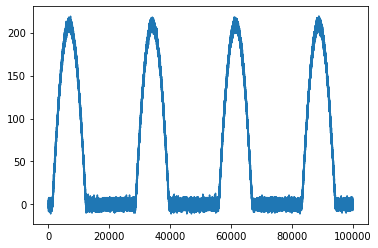

In [26]:
# This allows us to plot right here in the notebook
%matplotlib inline

# Hacking up a noisy pulse train
from matplotlib import pyplot as plt

@vectorize(['float32(float32, float32)'])
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result


n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

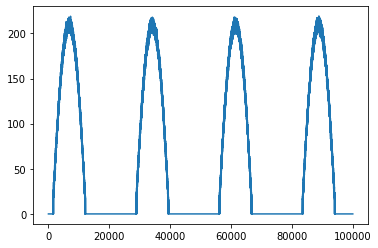

In [27]:
# This will throw an error until you successfully vectorize the `zero_suppress` function above.
# The noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15))

## Referências

- https://courses.nvidia.com/courses/course-v1:DLI+C-AC-01+V1/course/
- https://courses.nvidia.com/courses/course-v1:DLI+C-AC-02+V1/course/
- https://developer.nvidia.com/blog/how-query-device-properties-and-handle-errors-cuda-cc/